In [38]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [42]:
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.ensemble import forest
from sklearn import metrics
import pandas as pd
import numpy as np
from helpers import add_datepart, train_cats, proc_df
from IPython.display import display
import math
import matplotlib.pyplot as plt

In [2]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [3]:
df_raw = pd.read_csv("data/bulldozers/Train.csv", parse_dates=['saledate'], low_memory=False)
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [4]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,2011-10-25,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


```
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop("SalePrice", axis=1), df_raw.SalePrice)
```

Этот код не сработает по той причине, что мы не провели никакого Feature Engineering. Большинство алгоритмов машинного обучения может работать только с численными данными. Таким образом, например, категориальные переменные нам надо конвертировать из строк в численные категории. Гораздо интереснее что можно выжать из поля saledate - год, месяц, день, выходной ли это, начало(конец) ли года или квартала, как минимум. 

Для этого я воспользуюсь функцией из старой версии fastai, просто для удобства. Ничего мистического, просто мы берем стандартные атрибуты поля типа datetime в pandas и создаем из них новые колонки, исходную колонку дропаем.

In [5]:
add_datepart(df_raw, "saledate")
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

Как было сказано выше, строки при обучении не несут никакой полезной информации, нужно конвертировать их в специальный тип данных pandas - категории. Для этого снова возьмем готовый хелпер, но он еще проще - представление строк в виде категорий это стандартный метод pandas.

Эти изменения необходимы нам только на этапе тренировки модели.

In [6]:
train_cats(df_raw)

In [7]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [8]:
df_raw.UsageBand.cat.codes

0         1
1         1
2         0
3         0
4         2
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

Последняя трудность - отсутствующие значения, посмотрим долю пропущенных по каждой колонке:

In [9]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

Пропущенные значения можно обрабатывать разными способами, самый распространенный - заменять их на медианное значение по столбцу. Полезно так же иметь отдельную колонку с булевскими флажками и помечать, что этого значения не было и оно искусственное.

Для этого так же есть небольшой хелпер, который к тому же отделить для нас зависимую переменную:

In [10]:
df, y, nas = proc_df(df_raw, 'SalePrice')

Теперь, после предобработки датасета, наш исходный код должен сработать

In [11]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9881564289207972

При таком хорошем результате возникает подозрение, что мы переобучились. Стандартной практикой является наличие валидационного сета, который не участвует в тренировке, а только в проверке результатов модели.

Отделим от тренировочного сета столько же значений для валидации, сколько использует кагл для проверки этой задачи, то есть 12к записей

In [12]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
x_train, x_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

x_train.shape, y_train.shape, x_valid.shape 

((389125, 66), (389125,), (12000, 66))

In [34]:
def rmse(x, y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(x_train), y_train), rmse(m.predict(x_valid), y_valid),
          m.score(x_train, y_train), m.score(x_valid, y_valid)]
    if hasattr(m, "oob_score_"): res.append(m.oob_score_)
    print(res)

In [14]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 13min 57s, sys: 4.47 s, total: 14min 2s
Wall time: 3min 58s
[0.07576010556737585, 0.23540574374007442, 0.9880045659210798, 0.9010348962611823]


### Дерево

Как работает одно дерево? На каждом шаге мы проверяем все возможные переменные на все возможные бинарные деления и выбираем лучшее. После каждого разбиения мы имеем два сета и соответственно две метрики. Чтобы понять, что разбиение лучшее, надо взять среднее взвешенное этих метрик по количеству сэмплов в сэтах. Лучшее разбиение - максимальное улучшение этой взвешенной метрики по двум подсетам. 

Процесс продолжается, пока в листьях не останется по одному сэмплу или пока не достигнуто какое-то искусственное ограничение (глубина дерева, например, один из параметров класса RandomForestRegressor).

Так как полный датасет обрабатывается достаточно долгое время - около 4 минут на этой конкретной машине, - для быстрых экспериментов возьмем сабсет поменьше, валидационный сет оставим прежним и менять его в ходе экспериментов не будем, чтобы можно было отслеживать относительную результативность моделей без случайности.

In [15]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
x_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

Попробуем результаты регрессора с единственным маленьким деревом

In [16]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.519920223568028, 0.5828084601660874, 0.40670739105804843, 0.39340382300754084]


Если убрать ограничение по глубине дерева - результаты улучшатся, но на валидации будут все равно хуже оригинальной модели. Score на тренировочном сете - единица, наше дерево идеально предсказывает значения тренировочного сета, но плохо справляется с новыми данными.

In [17]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[4.351167857633658e-17, 0.5250335255435846, 1.0, 0.5077088306407709]


### Лес

Чтобы улучшить результаты, несколько деревьев объединяются в лес. Идея состоит в том, что мы берем несколько деревьев и переобучаем их на **случайном** сабсете данных. Каждое из них по отдельности показывает тот же результат, что мы видели выше - переобучается на тренировочных данных и не очень хорошо аппроксимирует новые. Но если мы возьмем много таких деревьем и возьмем среднее по их результатам, то итог будет достаточно хорошим. "Трюк" в том, что если сабсеты данных достаточно случайны, то ошибки деревьев не коррелируют друг с другом, следовательно их среднее стремится к нулю. Таким образом, из десяти "плохих" деревьем получается вполне себе рабочий "лес".


In [23]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.11224311552019761, 0.34873697751378974, 0.9723487389475427, 0.7828079260232532]


In [32]:
# predict whole validation set on each tree 
preds = np.stack([t.predict(x_valid) for t in m.estimators_])
# show each individual prediction, their mean and actual value
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([9.21034037, 9.10497986, 9.30565055, 9.13237883, 9.21034037,
        8.98719682, 8.95544812, 9.21034037, 9.07680898, 9.04782144]),
 9.124130571937332,
 9.104979856318357)

In [25]:
preds.shape

(10, 12000)

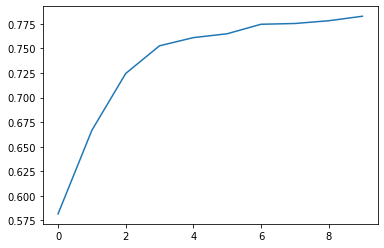

In [33]:
# plot mean preds for 1 tree, 2 trees, 3 trees up to 10

plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

### OOB-score 

У нас могут возникать разные проблемы с валидационным сетом - он слишком отличается от тренировочного и невозможно тренироваться? У нас мало данных на его выделение? 
В RandomForest есть практически уникальный трюк, позволяющий решать некоторые проблемы этого рода. Так как для каждого дерева вы выбираем случайный сабсет из тренировочного сета, то в качестве валидации для этого дерева мы можем использовать те элементы, которые не попали в тренировку. Дальше мы можем просто посчитать среднее по интересующим нам метрикам.

In [35]:
m = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
m.fit(x_train, y_train)
print_score(m)

[0.09598110443155461, 0.33069319271962555, 0.9797806587288223, 0.8047016904363802, 0.8546877208867649]


- Как мы знаем, каждое дерево берет случайный сабсет из всего датасета. Но ранее мы ограничили наш "полный" датасет 20к записями для ускорения работы. Гораздо более разумным подходом было бы ограничить возможную выборку для каждого дерева в отдельности. В таком случае, каждое дерево будет выбирать свой случайный сабсет из другого сабсета размером 20к, но при достаточном количестве деревьев в итоге весь тренировочный сет пройдет через модель.

In [44]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
x_train, x_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [45]:
# это лежит в хелпере
#set_rf_samples(20000)
forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, 20000))

In [46]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)
print_score(m)

/home/mayorov/.virtualenvs/fastai/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 1min 18s, sys: 623 ms, total: 1min 18s
Wall time: 24.4 s
[0.09043366830783706, 0.2499326060499649, 0.9829079119465371, 0.8884437750927655, -1.2974426030632173]


Это позволило улучшить результат и сохранить высокую скорость. Так как большее количество деревьев позволяет модели "увидеть" больше данных, то стоит увеличить n_estimators

In [47]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 5min 33s, sys: 2.06 s, total: 5min 35s
Wall time: 1min 37s
[0.07843159264684756, 0.2383233413978023, 0.9871436734775922, 0.8985665651043494, 0.9082607729280441]


In [48]:
# отменим сэмплирование
forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [49]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 5min 28s, sys: 3.76 s, total: 5min 32s
Wall time: 1min 36s
[0.07835093926420471, 0.23677916219909517, 0.9871701009170385, 0.8998767512140927, 0.9084666205656778]


- Еще один способ не переобучаться - указывать параметр `min_samples_leaf`. По умолчанию дерево строится до тех пор, пока не остается по одному сэмплу в каждом листе. Этот параметр позволяет изменять это число и тем самым уменьшать высоту дерева, что уменьшит вероятность переобучения. 

In [50]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 5min 3s, sys: 2.85 s, total: 5min 6s
Wall time: 1min 34s
[0.11508394928970404, 0.23188381889619647, 0.9723201112648587, 0.9039739947457092, 0.9083589067066228]


- `max_features` позволяет ограничить **колонки** ( а не семплы, как в предыдущем примере) случайной выборкой, в качестве значения этого параметра нужно указать долю, в которой будет произведен поиск наилучшего значения. То есть, еще раз, в предыдущем примере мы сэмплировали сами ряды данных, тут же мы сэмплируем фичи -- колонки.

В данном примере при каждом сплите будем искать лучшее значение в случайной выборке размером 50% от всех фич.

In [51]:
ь = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 5min 3s, sys: 1.28 s, total: 5min 4s
Wall time: 1min 32s
[0.11497933191811027, 0.23319043863055297, 0.9723704133444667, 0.9028887704986327, 0.90844453851581]
